# Imports

In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.combine import SMOTETomek

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler

from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping

# Loading data

In [2]:
laps = pd.read_csv("../raw_data/laps.csv")
track_status = pd.read_csv("../raw_data/track_status.csv")
weather = pd.read_csv("../raw_data/weather.csv")

/var/folders/f9/4fv5w4w54kggnjcsztxt19wm0000gn/T/ipykernel_52582/2337435297.py:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  laps = pd.read_csv("../raw_data/laps.csv")


# Put functions for testing

In [3]:
def add_race_progress(df):
    # Group data to get lap number per year per race
    grouped_data = df.groupby(by = ["Year", "Location"], as_index=False)["LapNumber"].max().rename(columns={"LapNumber":"TotalLaps"})
    grouped_data["Year_Location"] = grouped_data["Year"].map(str) + grouped_data["Location"]
    # Group data to get same info as grouped_data
    df["Year_Location"] = df["Year"].map(str) + df["Location"]
    # Merge data
    df = df.merge(grouped_data, on="Year_Location")
    # Clean data frame
    df.drop(columns=["Year_Location", "Year_y", "Location_y"], inplace=True)
    df["RaceProgress"] = df["LapNumber"] / df["TotalLaps"]
    df.rename(columns={"Location_x": "Location", "Year_x": "Year"}, inplace=True)
    return df

In [4]:
def mask_race_percentage(df, percentage):
    df = df[df["RaceProgress"] > percentage]
    return df

In [5]:
def get_tyre_stress_level(df):
    params = {'Mexico City': 4,
    'Lusail': 1,
    'Shanghai': 2,
    'Mugello': 1,
    'Hockenheim': 3,
    'Jeddah': 3,
    'Imola': 3,
    'São Paulo': 3,
    'Montréal': 3,
    'Singapore': 4,
    'Marina Bay': 4,
    'Barcelona': 1,
    'Spain': 1,
    'Spa-Francorchamps': 1,
    'Spielberg': 3,
    'Melbourne': 3,
    'Budapest': 3,
    'Nürburgring': 3,
    'Suzuka': 1,
    'Austin': 1,
    'Zandvoort': 1,
    'Bahrain': 3,
    'Portimão': 2,
    'Sochi': 4,
    'Monza': 1,
    'Yas Marina': 3,
    'Monaco': 5,
    'Miami': 3,
    'Istanbul': 1,
    'Baku': 3,
    'Monte Carlo': 5,
    'Yas Island': 3,
    'Le Castellet': 2,
    'Sakhir': 3,
    'Silverstone': 1}
    df["TyreStressLevel"] = df["Location"].map(params)
    return df


In [6]:
TIRE_MATCH = {
    'HYPERSOFT': 'SOFT',
    'ULTRASOFT': 'SOFT',
    'SUPERSOFT': 'SOFT',
    'SOFT': 'SOFT',
    'MEDIUM': 'MEDIUM',
    'HARD': 'HARD',
    'INTERMEDIATE': 'INTERMEDIATE',
    'WET': 'WET',
    'UNKNOWN': 'UNKNOWN'
}
def compound_recategorization(laps,tire_mapping):
    new_laps = laps.copy()
    new_laps['Compound']=laps['Compound'].map(tire_mapping)
    return new_laps

In [7]:
def compound_cleaning(laps,tire_mapping,backfilling=3):
    new_laps = laps.copy()
    new_laps = compound_recategorization(new_laps,tire_mapping)
    new_laps['Compound'].replace('UNKNOWN',None,inplace=True)
    new_laps['Compound'].fillna(method="bfill",limit=backfilling,inplace=True)
    return new_laps

In [8]:
def pitting(df):
    df['pitting_this_lap'] = np.where(laps['PitInTime'].notna(), True, False)
    return df

# Apply functions on laps data

In [9]:
laps = compound_recategorization(laps, TIRE_MATCH)
laps

,Unnamed: 0,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,...,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,Location,Year
0,0,0 days 00:08:53.241000,GAS,10,0 days 00:01:45.060000,1.0,NaN,0 days 00:00:04.103000,NaN,NaN,...,0 days 00:07:07.988000,NaN,1.0,17.0,False,NaN,False,False,Melbourne,2018
1,1,0 days 00:10:26.613000,GAS,10,0 days 00:01:33.372000,2.0,1.0,NaN,NaN,0 days 00:00:31.357000,...,0 days 00:08:53.241000,NaN,1.0,17.0,False,NaN,False,True,Melbourne,2018
2,2,0 days 00:11:59.474000,GAS,10,0 days 00:01:32.861000,3.0,1.0,NaN,NaN,0 days 00:00:31.160000,...,0 days 00:10:26.613000,NaN,1.0,17.0,False,NaN,False,True,Melbourne,2018
3,3,0 days 00:13:31.658000,GAS,10,0 days 00:01:32.184000,4.0,1.0,NaN,NaN,0 days 00:00:30.835000,...,0 days 00:11:59.474000,NaN,1.0,17.0,False,NaN,False,True,Melbourne,2018
4,4,0 days 00:15:03.990000,GAS,10,0 days 00:01:32.332000,5.0,1.0,NaN,NaN,0 days 00:00:30.716000,...,0 days 00:13:31.658000,NaN,2.0,17.0,False,NaN,False,True,Melbourne,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125754,125754,0 days 02:25:43.046000,SAR,2,0 days 00:01:21.280000,61.0,3.0,NaN,NaN,0 days 00:00:24.354000,...,0 days 02:24:21.766000,2023-06-04 14:25:21.773,1.0,20.0,False,NaN,False,True,Barcelona,2023
125755,125755,0 days 02:27:05.180000,SAR,2,0 days 00:01:22.134000,62.0,3.0,NaN,NaN,0 days 00:00:23.675000,...,0 days 02:25:43.046000,2023-06-04 14:26:43.053,1.0,20.0,False,NaN,False,True,Barcelona,2023
125756,125756,0 days 02:28:25.600000,SAR,2,0 days 00:01:20.420000,63.0,3.0,NaN,NaN,0 days 00:00:23.634000,...,0 days 02:27:05.180000,2023-06-04 14:28:05.187,1.0,20.0,False,NaN,False,True,Barcelona,2023
125757,125757,0 days 02:29:45.580000,SAR,2,0 days 00:01:19.980000,64.0,3.0,NaN,NaN,0 days 00:00:23.602000,...,0 days 02:28:25.600000,2023-06-04 14:29:25.607,1.0,20.0,False,NaN,False,True,Barcelona,2023


In [10]:
laps = add_race_progress(laps)
laps

,Unnamed: 0,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,...,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,Location,Year,TotalLaps,RaceProgress
0,0,0 days 00:08:53.241000,GAS,10,0 days 00:01:45.060000,1.0,NaN,0 days 00:00:04.103000,NaN,NaN,...,1.0,17.0,False,NaN,False,False,Melbourne,2018,58.0,0.017241
1,1,0 days 00:10:26.613000,GAS,10,0 days 00:01:33.372000,2.0,1.0,NaN,NaN,0 days 00:00:31.357000,...,1.0,17.0,False,NaN,False,True,Melbourne,2018,58.0,0.034483
2,2,0 days 00:11:59.474000,GAS,10,0 days 00:01:32.861000,3.0,1.0,NaN,NaN,0 days 00:00:31.160000,...,1.0,17.0,False,NaN,False,True,Melbourne,2018,58.0,0.051724
3,3,0 days 00:13:31.658000,GAS,10,0 days 00:01:32.184000,4.0,1.0,NaN,NaN,0 days 00:00:30.835000,...,1.0,17.0,False,NaN,False,True,Melbourne,2018,58.0,0.068966
4,4,0 days 00:15:03.990000,GAS,10,0 days 00:01:32.332000,5.0,1.0,NaN,NaN,0 days 00:00:30.716000,...,2.0,17.0,False,NaN,False,True,Melbourne,2018,58.0,0.086207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125754,125754,0 days 02:25:43.046000,SAR,2,0 days 00:01:21.280000,61.0,3.0,NaN,NaN,0 days 00:00:24.354000,...,1.0,20.0,False,NaN,False,True,Barcelona,2023,66.0,0.924242
125755,125755,0 days 02:27:05.180000,SAR,2,0 days 00:01:22.134000,62.0,3.0,NaN,NaN,0 days 00:00:23.675000,...,1.0,20.0,False,NaN,False,True,Barcelona,2023,66.0,0.939394
125756,125756,0 days 02:28:25.600000,SAR,2,0 days 00:01:20.420000,63.0,3.0,NaN,NaN,0 days 00:00:23.634000,...,1.0,20.0,False,NaN,False,True,Barcelona,2023,66.0,0.954545
125757,125757,0 days 02:29:45.580000,SAR,2,0 days 00:01:19.980000,64.0,3.0,NaN,NaN,0 days 00:00:23.602000,...,1.0,20.0,False,NaN,False,True,Barcelona,2023,66.0,0.969697


In [11]:
laps = compound_cleaning(laps, TIRE_MATCH)

In [12]:
laps

,Unnamed: 0,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,...,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,Location,Year,TotalLaps,RaceProgress
0,0,0 days 00:08:53.241000,GAS,10,0 days 00:01:45.060000,1.0,NaN,0 days 00:00:04.103000,NaN,NaN,...,1.0,17.0,False,NaN,False,False,Melbourne,2018,58.0,0.017241
1,1,0 days 00:10:26.613000,GAS,10,0 days 00:01:33.372000,2.0,1.0,NaN,NaN,0 days 00:00:31.357000,...,1.0,17.0,False,NaN,False,True,Melbourne,2018,58.0,0.034483
2,2,0 days 00:11:59.474000,GAS,10,0 days 00:01:32.861000,3.0,1.0,NaN,NaN,0 days 00:00:31.160000,...,1.0,17.0,False,NaN,False,True,Melbourne,2018,58.0,0.051724
3,3,0 days 00:13:31.658000,GAS,10,0 days 00:01:32.184000,4.0,1.0,NaN,NaN,0 days 00:00:30.835000,...,1.0,17.0,False,NaN,False,True,Melbourne,2018,58.0,0.068966
4,4,0 days 00:15:03.990000,GAS,10,0 days 00:01:32.332000,5.0,1.0,NaN,NaN,0 days 00:00:30.716000,...,2.0,17.0,False,NaN,False,True,Melbourne,2018,58.0,0.086207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125754,125754,0 days 02:25:43.046000,SAR,2,0 days 00:01:21.280000,61.0,3.0,NaN,NaN,0 days 00:00:24.354000,...,1.0,20.0,False,NaN,False,True,Barcelona,2023,66.0,0.924242
125755,125755,0 days 02:27:05.180000,SAR,2,0 days 00:01:22.134000,62.0,3.0,NaN,NaN,0 days 00:00:23.675000,...,1.0,20.0,False,NaN,False,True,Barcelona,2023,66.0,0.939394
125756,125756,0 days 02:28:25.600000,SAR,2,0 days 00:01:20.420000,63.0,3.0,NaN,NaN,0 days 00:00:23.634000,...,1.0,20.0,False,NaN,False,True,Barcelona,2023,66.0,0.954545
125757,125757,0 days 02:29:45.580000,SAR,2,0 days 00:01:19.980000,64.0,3.0,NaN,NaN,0 days 00:00:23.602000,...,1.0,20.0,False,NaN,False,True,Barcelona,2023,66.0,0.969697


In [13]:
laps = mask_race_percentage(laps, 0.1)
laps

,Unnamed: 0,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,...,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,Location,Year,TotalLaps,RaceProgress
5,5,0 days 00:16:42.170000,GAS,10,0 days 00:01:38.180000,6.0,1.0,NaN,NaN,0 days 00:00:30.866000,...,2.0,16.0,False,NaN,False,True,Melbourne,2018,58.0,0.103448
6,6,0 days 00:18:13.707000,GAS,10,0 days 00:01:31.537000,7.0,1.0,NaN,NaN,0 days 00:00:30.529000,...,2.0,16.0,False,NaN,False,True,Melbourne,2018,58.0,0.120690
7,7,0 days 00:19:45.026000,GAS,10,0 days 00:01:31.319000,8.0,1.0,NaN,NaN,0 days 00:00:30.438000,...,1.0,16.0,False,NaN,False,True,Melbourne,2018,58.0,0.137931
8,8,0 days 00:21:16.167000,GAS,10,0 days 00:01:31.141000,9.0,1.0,NaN,NaN,0 days 00:00:30.515000,...,2.0,16.0,False,NaN,False,True,Melbourne,2018,58.0,0.155172
9,9,0 days 00:22:47.303000,GAS,10,0 days 00:01:31.136000,10.0,1.0,NaN,NaN,0 days 00:00:30.548000,...,1.0,16.0,False,NaN,False,True,Melbourne,2018,58.0,0.172414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125754,125754,0 days 02:25:43.046000,SAR,2,0 days 00:01:21.280000,61.0,3.0,NaN,NaN,0 days 00:00:24.354000,...,1.0,20.0,False,NaN,False,True,Barcelona,2023,66.0,0.924242
125755,125755,0 days 02:27:05.180000,SAR,2,0 days 00:01:22.134000,62.0,3.0,NaN,NaN,0 days 00:00:23.675000,...,1.0,20.0,False,NaN,False,True,Barcelona,2023,66.0,0.939394
125756,125756,0 days 02:28:25.600000,SAR,2,0 days 00:01:20.420000,63.0,3.0,NaN,NaN,0 days 00:00:23.634000,...,1.0,20.0,False,NaN,False,True,Barcelona,2023,66.0,0.954545
125757,125757,0 days 02:29:45.580000,SAR,2,0 days 00:01:19.980000,64.0,3.0,NaN,NaN,0 days 00:00:23.602000,...,1.0,20.0,False,NaN,False,True,Barcelona,2023,66.0,0.969697


In [14]:
laps = get_tyre_stress_level(laps)
laps

/var/folders/f9/4fv5w4w54kggnjcsztxt19wm0000gn/T/ipykernel_52582/4032226164.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["TyreStressLevel"] = df["Location"].map(params)


,Unnamed: 0,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,...,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,Location,Year,TotalLaps,RaceProgress,TyreStressLevel
5,5,0 days 00:16:42.170000,GAS,10,0 days 00:01:38.180000,6.0,1.0,NaN,NaN,0 days 00:00:30.866000,...,16.0,False,NaN,False,True,Melbourne,2018,58.0,0.103448,3
6,6,0 days 00:18:13.707000,GAS,10,0 days 00:01:31.537000,7.0,1.0,NaN,NaN,0 days 00:00:30.529000,...,16.0,False,NaN,False,True,Melbourne,2018,58.0,0.120690,3
7,7,0 days 00:19:45.026000,GAS,10,0 days 00:01:31.319000,8.0,1.0,NaN,NaN,0 days 00:00:30.438000,...,16.0,False,NaN,False,True,Melbourne,2018,58.0,0.137931,3
8,8,0 days 00:21:16.167000,GAS,10,0 days 00:01:31.141000,9.0,1.0,NaN,NaN,0 days 00:00:30.515000,...,16.0,False,NaN,False,True,Melbourne,2018,58.0,0.155172,3
9,9,0 days 00:22:47.303000,GAS,10,0 days 00:01:31.136000,10.0,1.0,NaN,NaN,0 days 00:00:30.548000,...,16.0,False,NaN,False,True,Melbourne,2018,58.0,0.172414,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125754,125754,0 days 02:25:43.046000,SAR,2,0 days 00:01:21.280000,61.0,3.0,NaN,NaN,0 days 00:00:24.354000,...,20.0,False,NaN,False,True,Barcelona,2023,66.0,0.924242,1
125755,125755,0 days 02:27:05.180000,SAR,2,0 days 00:01:22.134000,62.0,3.0,NaN,NaN,0 days 00:00:23.675000,...,20.0,False,NaN,False,True,Barcelona,2023,66.0,0.939394,1
125756,125756,0 days 02:28:25.600000,SAR,2,0 days 00:01:20.420000,63.0,3.0,NaN,NaN,0 days 00:00:23.634000,...,20.0,False,NaN,False,True,Barcelona,2023,66.0,0.954545,1
125757,125757,0 days 02:29:45.580000,SAR,2,0 days 00:01:19.980000,64.0,3.0,NaN,NaN,0 days 00:00:23.602000,...,20.0,False,NaN,False,True,Barcelona,2023,66.0,0.969697,1


In [15]:
laps = pitting(laps)

/var/folders/f9/4fv5w4w54kggnjcsztxt19wm0000gn/T/ipykernel_52582/3543978339.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pitting_this_lap'] = np.where(laps['PitInTime'].notna(), True, False)


# Drop columns

In [16]:
laps.columns

Index(['Unnamed: 0', 'Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber',
       'Stint', 'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time',
       'Sector3Time', 'Sector1SessionTime', 'Sector2SessionTime',
       'Sector3SessionTime', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST',
       'IsPersonalBest', 'Compound', 'TyreLife', 'FreshTyre', 'Team',
       'LapStartTime', 'LapStartDate', 'TrackStatus', 'Position', 'Deleted',
       'DeletedReason', 'FastF1Generated', 'IsAccurate', 'Location', 'Year',
       'TotalLaps', 'RaceProgress', 'TyreStressLevel', 'pitting_this_lap'],
      dtype='object')

In [17]:
laps.drop(columns=['Unnamed: 0', 'Time', 'DriverNumber', 'LapTime',
       'Stint', 'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time',
       'Sector3Time', 'Sector1SessionTime', 'Sector2SessionTime',
       'Sector3SessionTime', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 
       'LapStartTime', 'LapStartDate', 'Deleted',
       'DeletedReason', 'FastF1Generated', 'IsAccurate', 'TrackStatus'], inplace = True)

/var/folders/f9/4fv5w4w54kggnjcsztxt19wm0000gn/T/ipykernel_52582/3923728563.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps.drop(columns=['Unnamed: 0', 'Time', 'DriverNumber', 'LapTime',


# NaN management

In [18]:
# Driver à checker à la main ✅
# SpeedI1 / SpeedI2 / SpeedFL / SpeedST à supprimer ✅
# IsPersonalBest = most frequent ✅
# Compound à checker à la main ✅
# Team à checker à la main ✅
# TrackStatus à checker à la main (merge avec Track Status) ✅
# Position à checker à la main ✅

## Fill Driver

In [19]:
laps["Driver"] = laps["Driver"].fillna("OCO")

/var/folders/f9/4fv5w4w54kggnjcsztxt19wm0000gn/T/ipykernel_52582/1099988079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps["Driver"] = laps["Driver"].fillna("OCO")


## Fill personal best

In [20]:
laps["IsPersonalBest"] = laps["IsPersonalBest"].fillna(False)

/var/folders/f9/4fv5w4w54kggnjcsztxt19wm0000gn/T/ipykernel_52582/1618413017.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps["IsPersonalBest"] = laps["IsPersonalBest"].fillna(False)


## Fill compound (Drop Spa Francorchamps to solve problem)

In [21]:
laps[laps["Compound"].isna()]


,Driver,LapNumber,IsPersonalBest,Compound,TyreLife,FreshTyre,Team,Position,Location,Year,TotalLaps,RaceProgress,TyreStressLevel,pitting_this_lap
79739,HAM,1.0,False,None,1.0,False,Mercedes,3.0,Spa-Francorchamps,2021,3.0,0.333333,1,False
79740,HAM,2.0,False,None,2.0,False,Mercedes,3.0,Spa-Francorchamps,2021,3.0,0.666667,1,False
79741,HAM,3.0,False,None,3.0,False,Mercedes,3.0,Spa-Francorchamps,2021,3.0,1.000000,1,True
79742,RIC,1.0,False,None,1.0,False,McLaren,4.0,Spa-Francorchamps,2021,3.0,0.333333,1,False
79743,RIC,2.0,False,None,2.0,False,McLaren,4.0,Spa-Francorchamps,2021,3.0,0.666667,1,False
79744,RIC,3.0,False,None,3.0,False,McLaren,4.0,Spa-Francorchamps,2021,3.0,1.000000,1,True
79745,VET,1.0,False,None,3.0,False,Aston Martin,5.0,Spa-Francorchamps,2021,3.0,0.333333,1,False
79746,VET,2.0,False,None,4.0,False,Aston Martin,5.0,Spa-Francorchamps,2021,3.0,0.666667,1,False
79747,VET,3.0,False,None,5.0,False,Aston Martin,5.0,Spa-Francorchamps,2021,3.0,1.000000,1,True
79748,GAS,1.0,False,None,1.0,False,AlphaTauri,6.0,Spa-Francorchamps,2021,3.0,0.333333,1,False


In [22]:
driver_missing_compound = laps[laps["Compound"].isna()].Driver
set(driver_missing_compound)

{'ALO', 'GAS', 'HAM', 'NOR', 'OCO', 'PER', 'RIC', 'SAI', 'VET'}

In [23]:
laps[(laps["Driver"] == "ALO") & (laps["Location"] == "Spa-Francorchamps") & (laps["Year"] == 2021)]

,Driver,LapNumber,IsPersonalBest,Compound,TyreLife,FreshTyre,Team,Position,Location,Year,TotalLaps,RaceProgress,TyreStressLevel,pitting_this_lap
79763,ALO,1.0,False,None,1.0,False,Alpine,11.0,Spa-Francorchamps,2021,3.0,0.333333,1,False
79764,ALO,2.0,False,None,2.0,False,Alpine,11.0,Spa-Francorchamps,2021,3.0,0.666667,1,False
79765,ALO,3.0,False,None,3.0,False,Alpine,11.0,Spa-Francorchamps,2021,3.0,1.000000,1,True


## Fill team

In [24]:
laps[laps["Team"].isna()]

,Driver,LapNumber,IsPersonalBest,Compound,TyreLife,FreshTyre,Team,Position,Location,Year,TotalLaps,RaceProgress,TyreStressLevel,pitting_this_lap
52849,OCO,8.0,True,MEDIUM,4.0,True,NaN,16.0,Budapest,2020,70.0,0.114286,3,False
52850,OCO,9.0,True,MEDIUM,5.0,True,NaN,16.0,Budapest,2020,70.0,0.128571,3,False
52851,OCO,10.0,True,MEDIUM,6.0,True,NaN,16.0,Budapest,2020,70.0,0.142857,3,False
52852,OCO,11.0,False,MEDIUM,7.0,True,NaN,16.0,Budapest,2020,70.0,0.157143,3,False
52853,OCO,12.0,False,MEDIUM,8.0,True,NaN,16.0,Budapest,2020,70.0,0.171429,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52906,OCO,65.0,False,HARD,34.0,True,NaN,13.0,Budapest,2020,70.0,0.928571,3,False
52907,OCO,66.0,False,HARD,35.0,True,NaN,13.0,Budapest,2020,70.0,0.942857,3,False
52908,OCO,67.0,False,HARD,36.0,True,NaN,13.0,Budapest,2020,70.0,0.957143,3,False
52909,OCO,68.0,False,HARD,37.0,True,NaN,13.0,Budapest,2020,70.0,0.971429,3,False


In [25]:
laps[laps["Team"].isna()].Driver.value_counts()

Driver
OCO    62
Name: count, dtype: int64

In [26]:
laps["Team"].value_counts()

Team
Mercedes             12074
Red Bull Racing      11507
McLaren              11413
Ferrari              11384
Williams             11241
Haas F1 Team         10693
AlphaTauri            6938
Alfa Romeo Racing     6369
Renault               5732
Aston Martin          5533
Alpine                5493
Racing Point          4594
Toro Rosso            4026
Alfa Romeo            2993
Sauber                1932
Force India           1202
Name: count, dtype: int64

In [27]:
laps["Team"] = laps["Team"].fillna("Renault")

/var/folders/f9/4fv5w4w54kggnjcsztxt19wm0000gn/T/ipykernel_52582/3066765855.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps["Team"] = laps["Team"].fillna("Renault")


In [28]:
laps[laps["Team"].isna()]

,Driver,LapNumber,IsPersonalBest,Compound,TyreLife,FreshTyre,Team,Position,Location,Year,TotalLaps,RaceProgress,TyreStressLevel,pitting_this_lap


In [29]:
laps[(laps["Location"] == "Spielberg") & (laps["Year"] == 2018) & (laps["Driver"] == "HAR")]

,Driver,LapNumber,IsPersonalBest,Compound,TyreLife,FreshTyre,Team,Position,Location,Year,TotalLaps,RaceProgress,TyreStressLevel,pitting_this_lap
9080,HAR,8.0,False,SOFT,7.0,True,Toro Rosso,17.0,Spielberg,2018,71.0,0.112676,3,False
9081,HAR,9.0,False,SOFT,8.0,True,Toro Rosso,17.0,Spielberg,2018,71.0,0.126761,3,False
9082,HAR,10.0,False,SOFT,9.0,True,Toro Rosso,18.0,Spielberg,2018,71.0,0.140845,3,False
9083,HAR,11.0,True,SOFT,10.0,True,Toro Rosso,18.0,Spielberg,2018,71.0,0.154930,3,False
9084,HAR,12.0,False,SOFT,11.0,True,Toro Rosso,17.0,Spielberg,2018,71.0,0.169014,3,False
9085,HAR,13.0,False,SOFT,12.0,True,Toro Rosso,17.0,Spielberg,2018,71.0,0.183099,3,False
9086,HAR,14.0,False,SOFT,13.0,True,Toro Rosso,16.0,Spielberg,2018,71.0,0.197183,3,False
9087,HAR,15.0,False,SOFT,14.0,True,Toro Rosso,16.0,Spielberg,2018,71.0,0.211268,3,False
9088,HAR,16.0,False,SOFT,15.0,True,Toro Rosso,13.0,Spielberg,2018,71.0,0.225352,3,False
9089,HAR,17.0,True,SOFT,16.0,True,Toro Rosso,13.0,Spielberg,2018,71.0,0.239437,3,False


# Fill position

In [30]:
laps_with_na_position = laps[laps["Position"].isna()]
laps_with_na_position["Location_Year"] = laps_with_na_position["Location"] + laps_with_na_position["Year"].map(str)

/var/folders/f9/4fv5w4w54kggnjcsztxt19wm0000gn/T/ipykernel_52582/1086801290.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps_with_na_position["Location_Year"] = laps_with_na_position["Location"] + laps_with_na_position["Year"].map(str)


In [31]:
laps["Position"] = laps["Position"].fillna(method = "ffill")

/var/folders/f9/4fv5w4w54kggnjcsztxt19wm0000gn/T/ipykernel_52582/4146636770.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps["Position"] = laps["Position"].fillna(method = "ffill")


# Drop duplicates

In [32]:
laps.duplicated().sum()

7093

In [33]:
laps.drop_duplicates(inplace=True)

/var/folders/f9/4fv5w4w54kggnjcsztxt19wm0000gn/T/ipykernel_52582/1756322699.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps.drop_duplicates(inplace=True)


In [34]:
laps["pitting_this_lap"] = laps["pitting_this_lap"].apply(lambda x: 1 if x == True else 0)

/var/folders/f9/4fv5w4w54kggnjcsztxt19wm0000gn/T/ipykernel_52582/376603030.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps["pitting_this_lap"] = laps["pitting_this_lap"].apply(lambda x: 1 if x == True else 0)


In [35]:
laps

,Driver,LapNumber,IsPersonalBest,Compound,TyreLife,FreshTyre,Team,Position,Location,Year,TotalLaps,RaceProgress,TyreStressLevel,pitting_this_lap
5,GAS,6.0,False,SOFT,5.0,True,Toro Rosso,16.0,Melbourne,2018,58.0,0.103448,3,0
6,GAS,7.0,True,SOFT,6.0,True,Toro Rosso,16.0,Melbourne,2018,58.0,0.120690,3,0
7,GAS,8.0,True,SOFT,7.0,True,Toro Rosso,16.0,Melbourne,2018,58.0,0.137931,3,0
8,GAS,9.0,True,SOFT,8.0,True,Toro Rosso,16.0,Melbourne,2018,58.0,0.155172,3,0
9,GAS,10.0,True,SOFT,9.0,True,Toro Rosso,16.0,Melbourne,2018,58.0,0.172414,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125754,SAR,61.0,False,HARD,25.0,True,Williams,20.0,Barcelona,2023,66.0,0.924242,1,0
125755,SAR,62.0,False,HARD,26.0,True,Williams,20.0,Barcelona,2023,66.0,0.939394,1,0
125756,SAR,63.0,False,HARD,27.0,True,Williams,20.0,Barcelona,2023,66.0,0.954545,1,0
125757,SAR,64.0,False,HARD,28.0,True,Williams,20.0,Barcelona,2023,66.0,0.969697,1,0


# Set X & y

In [36]:
# TODO:
# Quid du Y ? => Fill NaN by 0 and not NaN by 1 OK 
# Quid du X ? OK 
# Train test split x2 pour val 
# Pipeline => tout dedans 
# Scaling des données fit train transform train val test 
# Pipeline sur le OHE 
# Quid du rebalancing ?

# Preproc (OHE encoder / Scaling) - Pipeline
# TTS 
# SMOTE - Pipeline


# Séparation X & y 
# Train test val split
# Preproc la donnée avec OHE + Scaling  
# SMOTE sur Train 

In [37]:
y = laps["pitting_this_lap"]

In [38]:
X = laps.drop(columns="pitting_this_lap")

# Train Test Val Split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [40]:
y_train.shape, y_test.shape

((90179,), (15914,))

In [41]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [42]:
y_train.shape, y_val.shape

((72143,), (18036,))

# Preprocessing

In [43]:
feat_numerical = sorted(X.select_dtypes(include=["int64", "float64"]).columns)

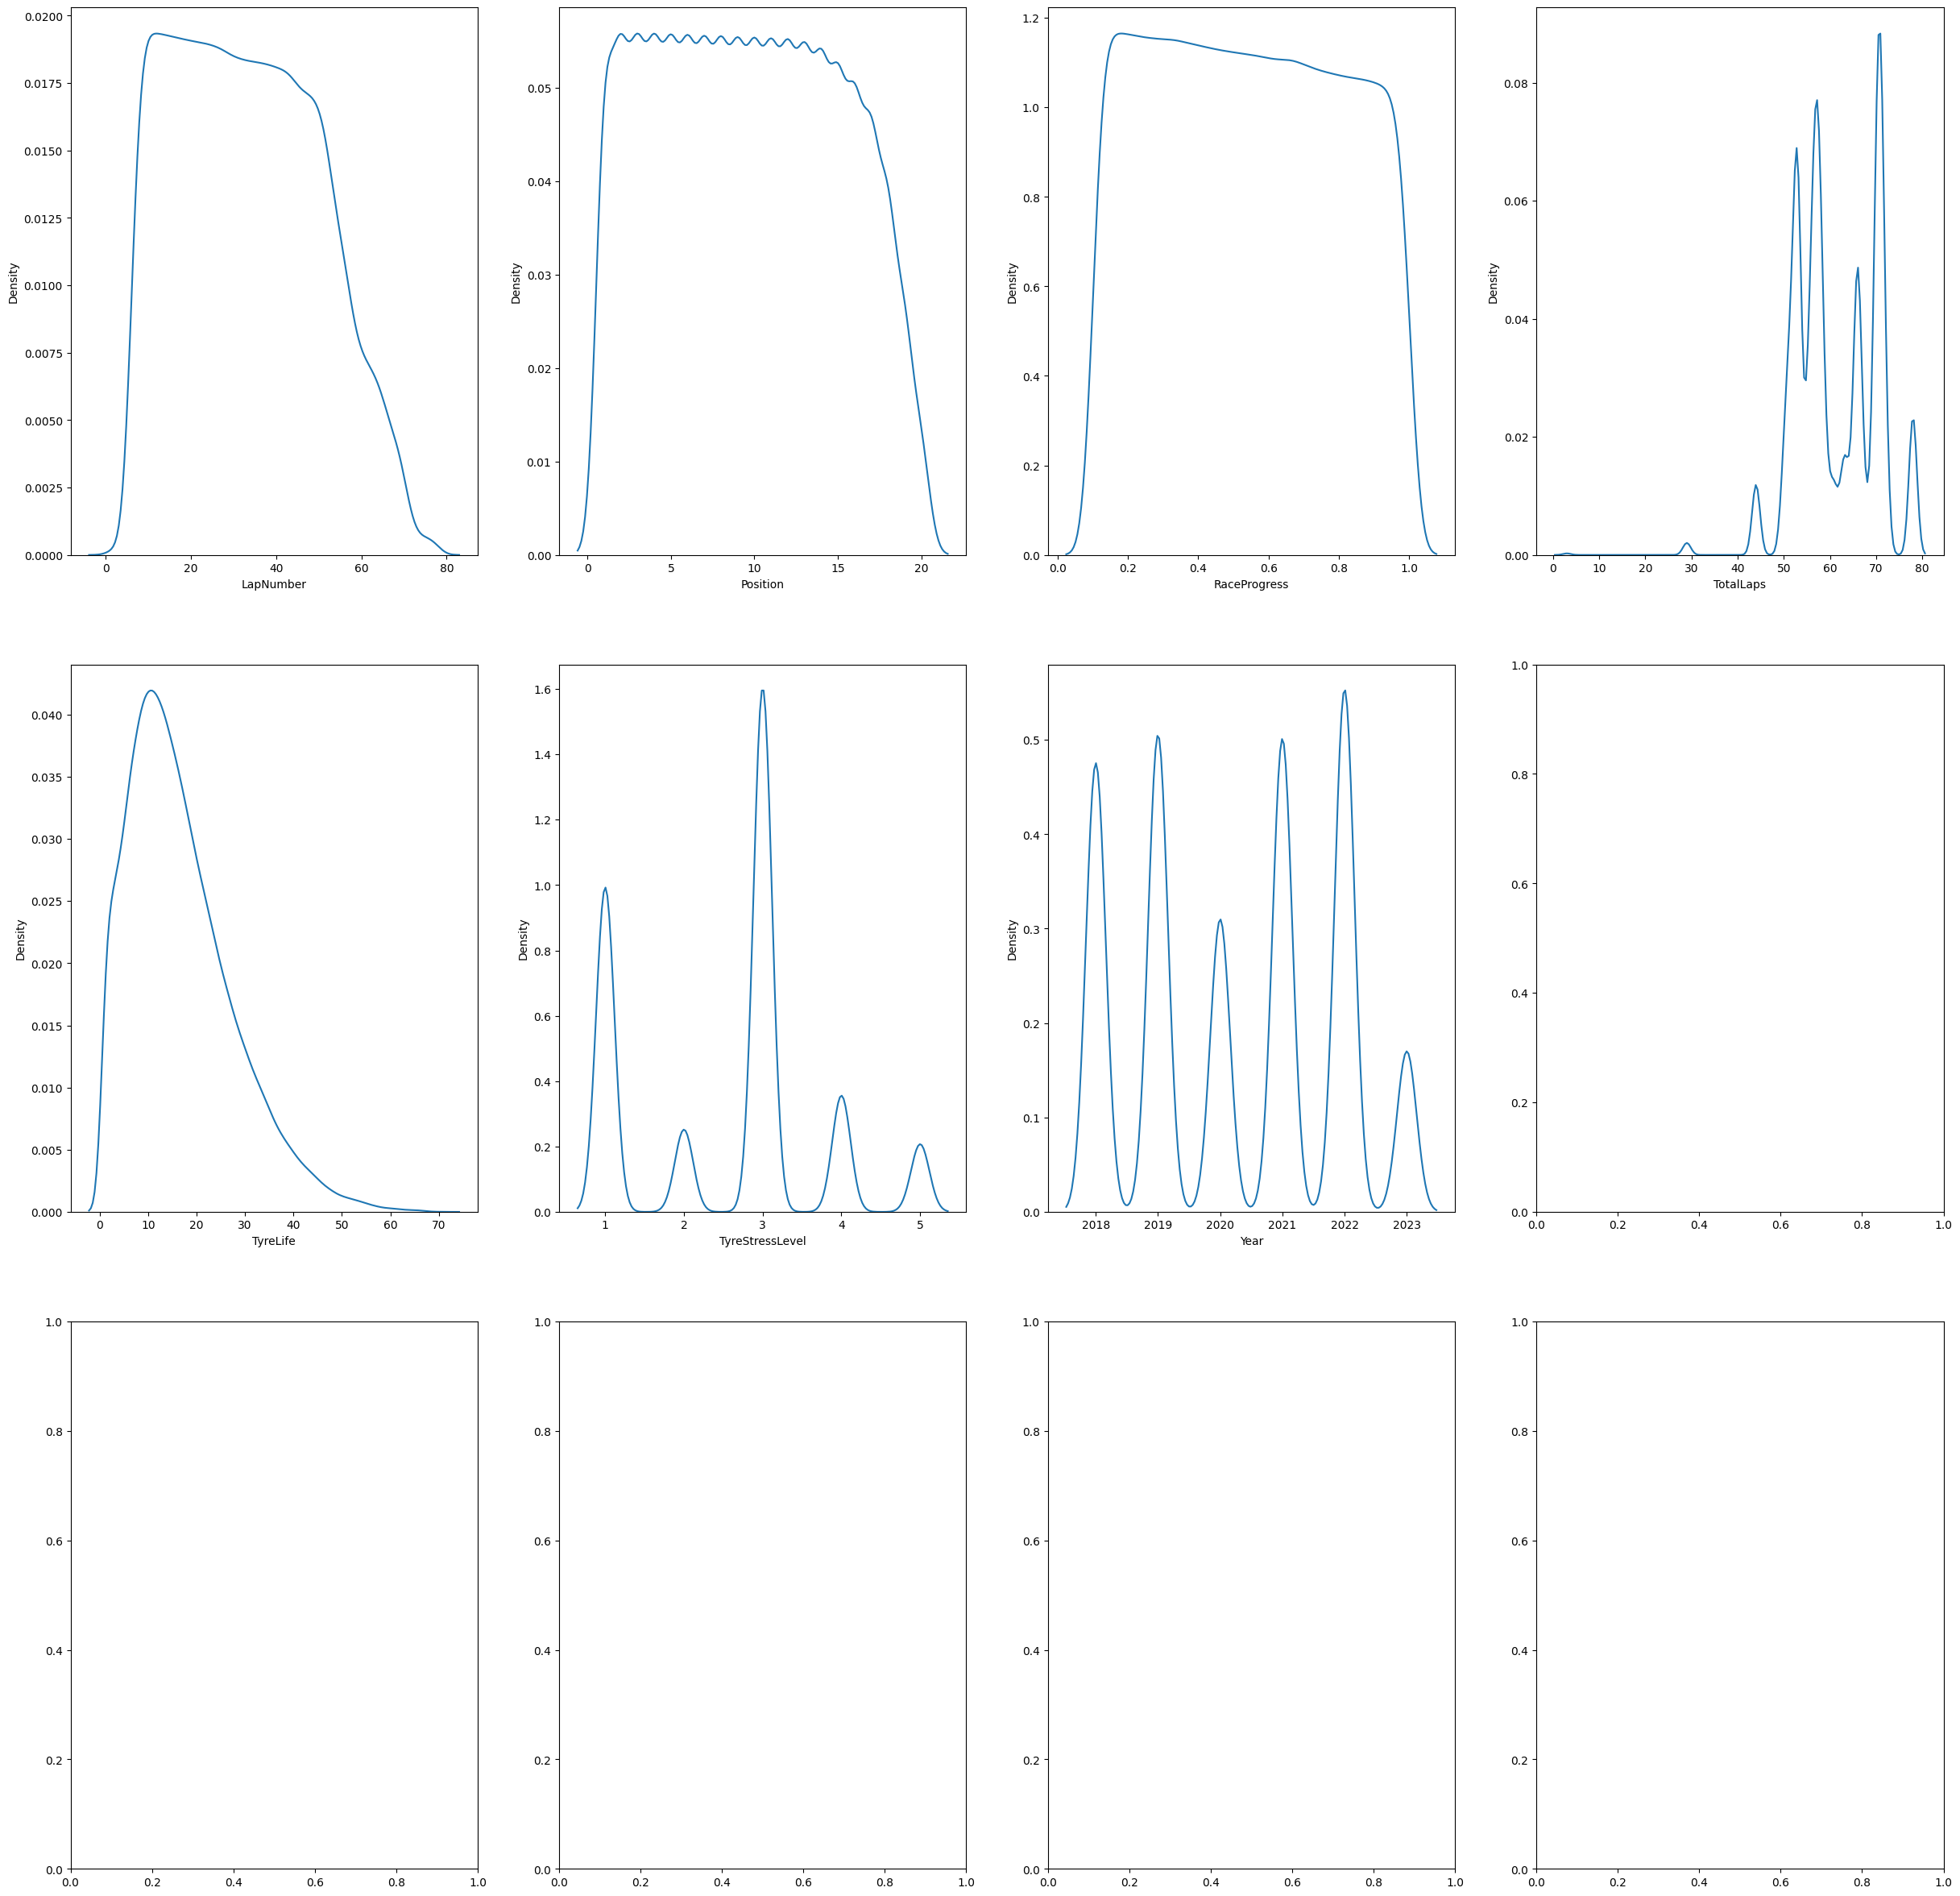

In [44]:
fig, axs = plt.subplots(3,4, figsize=(30, 30))

axs = axs.ravel()

for ax, column in zip(axs, feat_numerical):
    sns.kdeplot(x=column, data=X, ax=ax)

In [ ]:
X.columns

Index(['Driver', 'LapNumber', 'IsPersonalBest', 'Compound', 'TyreLife',
       'FreshTyre', 'Team', 'Position', 'Location', 'Year', 'TotalLaps',
       'RaceProgress', 'TyreStressLevel'],
      dtype='object')

In [46]:
X.dtypes

Driver              object
LapNumber          float64
IsPersonalBest        bool
Compound            object
TyreLife           float64
FreshTyre             bool
Team                object
Position           float64
Location            object
Year                 int64
TotalLaps          float64
RaceProgress       float64
TyreStressLevel      int64
dtype: object

In [47]:
cat_features = ["Driver", "Compound", "Team", "IsPersonalBest", "FreshTyre", "Location"]
cat_features_preproc = make_pipeline(OneHotEncoder(sparse=False, handle_unknown="ignore"))
num_features = ["LapNumber", "TyreLife", "Position", "TotalLaps", "TyreStressLevel"]
num_features_preproc = make_pipeline(RobustScaler())

In [48]:
preproc_baseline = make_column_transformer((cat_features_preproc, cat_features),
                                           (num_features_preproc, num_features),
                                           remainder="passthrough")

In [49]:
preproc_baseline

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['Driver', 'Compound', 'Team',
                                  'IsPersonalBest', 'FreshTyre', 'Location']),
                                ('pipeline-2',
                                 Pipeline(steps=[('robustscaler',
                                                  RobustScaler())]),
                                 ['LapNumber', 'TyreLife', 'Position',
                                  'TotalLaps', 'TyreStressLevel'])])

In [50]:
preproc_baseline.fit(X_train)
X_train_preproc = preproc_baseline.transform(X_train)
X_test_preproc = preproc_baseline.transform(X_test)
X_val_preproc = preproc_baseline.transform(X_val)

/Users/etienneginoux/.pyenv/versions/3.10.6/envs/f1-binottor/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# SMOTE & Tomek

In [51]:
smt = SMOTETomek(sampling_strategy=0.3)
X_train_preproc_resamp, y_train_resamp = smt.fit_resample(X_train_preproc, y_train)

In [52]:
y_train.value_counts(), y_train_resamp.value_counts() 

(pitting_this_lap
 0    69836
 1     2307
 Name: count, dtype: int64,
 pitting_this_lap
 0    69464
 1    20578
 Name: count, dtype: int64)

# Model

#### Faire un dropout / Mettre en L1 / Augmenter les neurones / Faire une confusion matrix / Faire les courbes d'apprentissage 

In [53]:
X_train_preproc_resamp.shape

(90042, 103)

In [75]:
model = models.Sequential()
model.add(layers.Dense(64, activation="relu", input_dim = 103))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(64, activation="relu"))

model.add(layers.Dense(1, activation="sigmoid"))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

In [76]:
es = EarlyStopping(patience=10, restore_best_weights=True)

In [77]:
model.fit(X_train_preproc_resamp, y_train_resamp, batch_size=256, epochs=100, validation_data=(X_val_preproc, y_val), callbacks=[es])

Epoch 1/100
704/704 [==============================] - 4s 3ms/step - loss: 1.2494 - accuracy: 0.7301 - val_loss: 0.5736 - val_accuracy: 0.7195
Epoch 2/100
704/704 [==============================] - 2s 4ms/step - loss: 0.5706 - accuracy: 0.7457 - val_loss: 0.1480 - val_accuracy: 0.9662
Epoch 3/100
704/704 [==============================] - 3s 4ms/step - loss: 0.5060 - accuracy: 0.7597 - val_loss: 0.6704 - val_accuracy: 0.5988
Epoch 4/100
704/704 [==============================] - 2s 3ms/step - loss: 0.4918 - accuracy: 0.7640 - val_loss: 0.1807 - val_accuracy: 0.9637
Epoch 5/100
704/704 [==============================] - 3s 4ms/step - loss: 0.4932 - accuracy: 0.7640 - val_loss: 0.2676 - val_accuracy: 0.9157
Epoch 6/100
704/704 [==============================] - 3s 5ms/step - loss: 0.4791 - accuracy: 0.7680 - val_loss: 0.3814 - val_accuracy: 0.8185
Epoch 7/100
704/704 [==============================] - 3s 5ms/step - loss: 0.4690 - accuracy: 0.7700 - val_loss: 0.4203 - val_accuracy: 0.7803

In [78]:
y_pred = model.predict(X_test_preproc)

498/498 [==============================] - 1s 2ms/step


In [86]:
y_pred

array([[0.05218308],
       [0.00406589],
       [0.06820451],
       ...,
       [0.03799183],
       [0.06002471],
       [0.16868575]], dtype=float32)

In [79]:
y_pred_encode = []
for prediction in y_pred:
    if prediction < 0.5:
        y_pred_encode.append(0)
    else: 
        y_pred_encode.append(1)

In [80]:
y_pred_encode

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


### Baselines with 3 layers / 32 neurons / batch_size 256 / 10 patience / 16 epochs

In [65]:
baseline_acc = accuracy_score(y_test, y_pred_encode)
baseline_acc

0.9663818021867538

In [66]:
baseline_f1 = f1_score(y_test, y_pred_encode)
baseline_f1

0.014732965009208102

### Baselines with 3 layers / 32 neurons / batch_size 128 / 20 patience / 25 epochs

In [73]:
second_acc = accuracy_score(y_test, y_pred_encode)
second_acc

0.9665074776925977

In [74]:
second_f1 = f1_score(y_test, y_pred_encode)
second_f1

0.0074487895716946

### Baselines with 3 layers / 64 neurons / batch_size 128 / 10 patience / X epochs

In [81]:
third_acc = accuracy_score(y_test, y_pred_encode)
third_acc

0.9666331531984417

In [82]:
third_f1 = f1_score(y_test, y_pred_encode)
third_f1

0.0

In [84]:
third_precision = precision_score(y_test, y_pred_encode)


/Users/etienneginoux/.pyenv/versions/3.10.6/envs/f1-binottor/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [85]:
third_precision

0.0